<a href="https://colab.research.google.com/github/T-art-coder/Python-notebooks/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%9C%D0%90%D0%A3_c%D0%BE%D0%BA%D1%80_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка пакетов

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
!pip install pmdarima
import pmdarima as pm

In [ ]:
import statsmodels.tsa.api as smt

import scipy.stats as stats

## Напишем функцию для анализа временного ряда, поиска автокорреляции и иллюстрации графика квантилей (прямая изображает нормальное распределение)
def tsplot(y, lags=None, figsize=(12,10), style='bmh', title = False):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title) ## Моя небольшая корректировка :3
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Анализ МАУ, исследовательский


In [ ]:
df = pd.read_excel('/content/MAU_price.xlsx', parse_dates=['date'], index_col='date')

df.head()

,price,price_cl,volume,value,num_trades
date,,,,,
2016-07-01,31460,26216.666667,1080,33976800,4
2016-07-04,31458,26215.000000,1080,33975000,4
2016-07-05,31449,26207.500000,1080,33965400,4
2016-07-06,31403,26169.166667,1080,33915300,3
2016-07-07,31560,26300.000000,1080,34084800,2


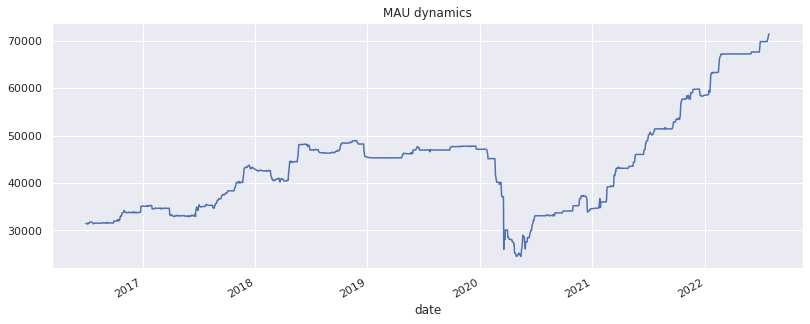

In [ ]:
df['price'].plot(figsize=(12,5))
plt.title('MAU dynamics')
plt.show()

Количество торгов и цены

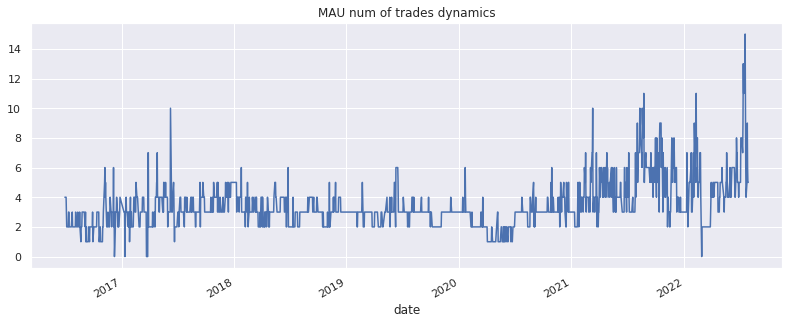

In [ ]:
df['num_trades'].plot(figsize=(12,5))
plt.title('MAU num of trades dynamics')
plt.show()

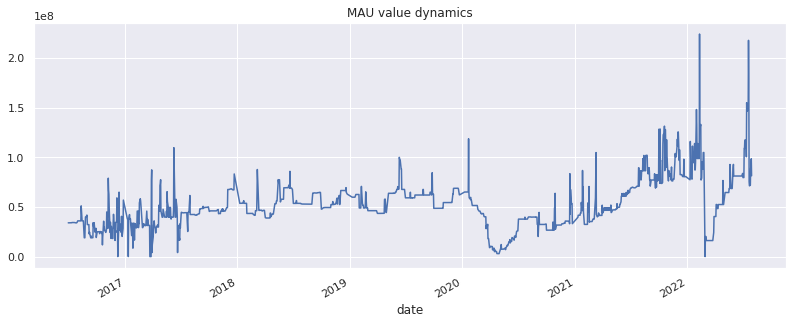

In [ ]:
df['value'].plot(figsize=(12,5))
plt.title('MAU value dynamics')
plt.show()

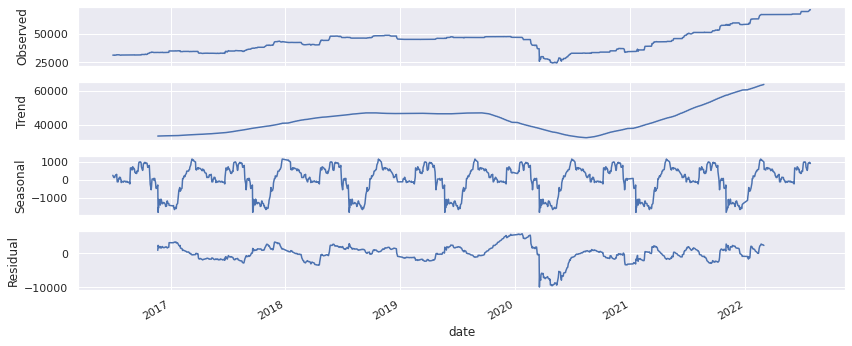

In [ ]:
decomposition = seasonal_decompose(df['price'], freq=200, model='additive')
plt.rcParams['figure.figsize'] = 12, 5
decomposition.plot()
plt.show();

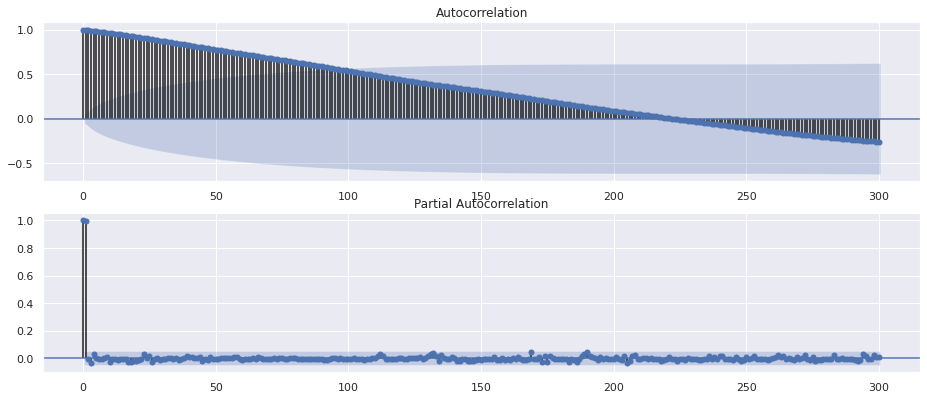

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df['price'], lags=300, ax=ax1)
ax2 = plot_pacf(df['price'], lags=300, ax=ax2)
plt.show()

## ACF говорит о том, что на дневных значениях есть устойчивая автокорреляция - т.е. есть тренд, а не какая-то сезонность

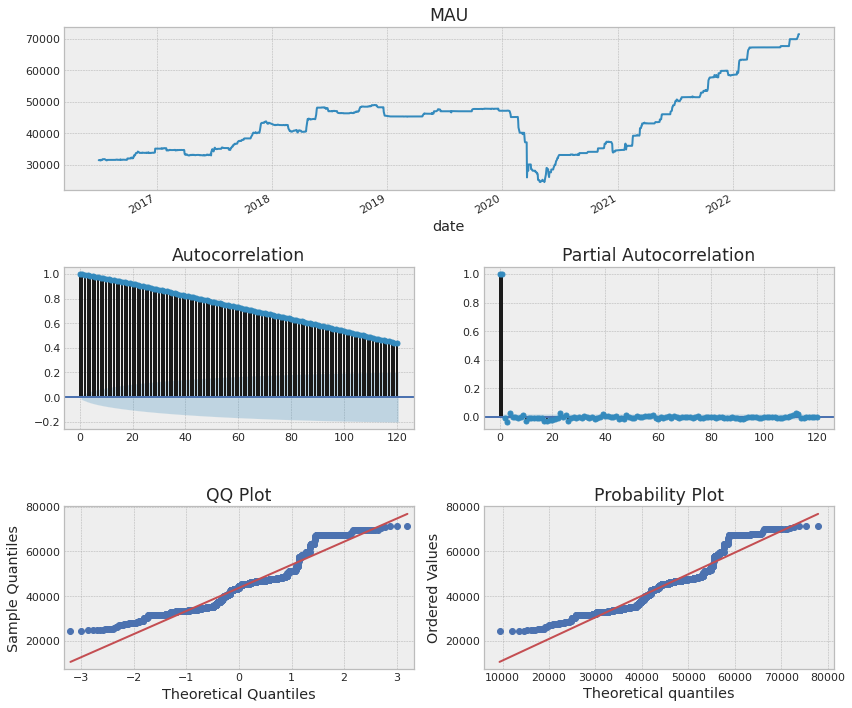

In [ ]:
tsplot(df['price'], lags=120, title = 'MAU')

In [ ]:
df[df]

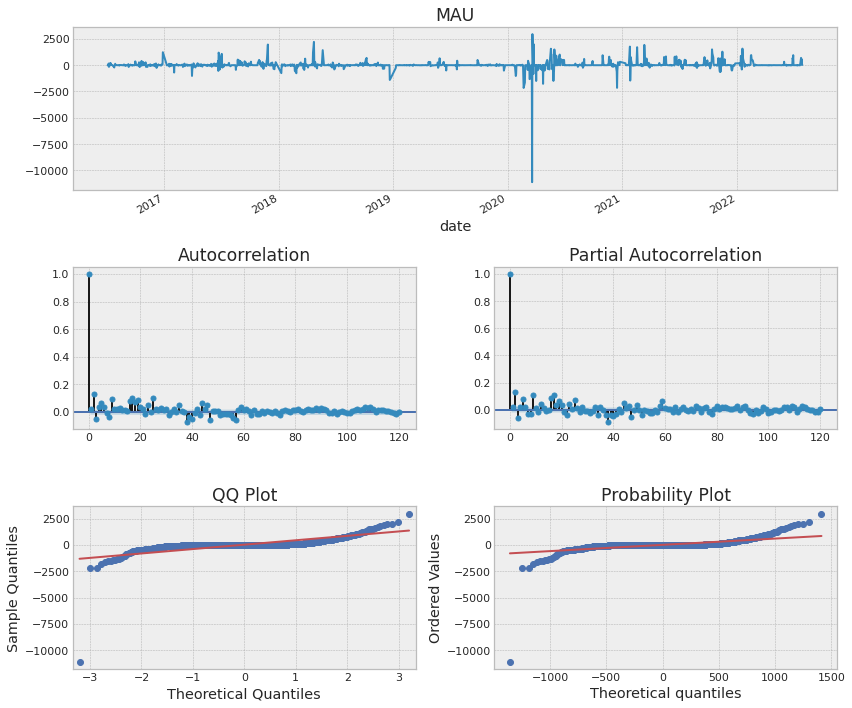

In [ ]:
tsplot(df.price.diff().dropna(), lags=120, title = 'MAU')

In [ ]:
df_21_22 = df[1094:]
df_21_22.head()

,price,price_cl,volume,value,num_trades
date,,,,,
2021-01-11,34705,28920.833333,1140,39563400,3
2021-01-12,34703,28919.166667,1200,41643000,2
2021-01-13,34707,28922.500000,1200,41648400,2
2021-01-14,34708,28923.333333,1200,41649000,2
2021-01-15,34703,28919.166667,1200,41643000,2


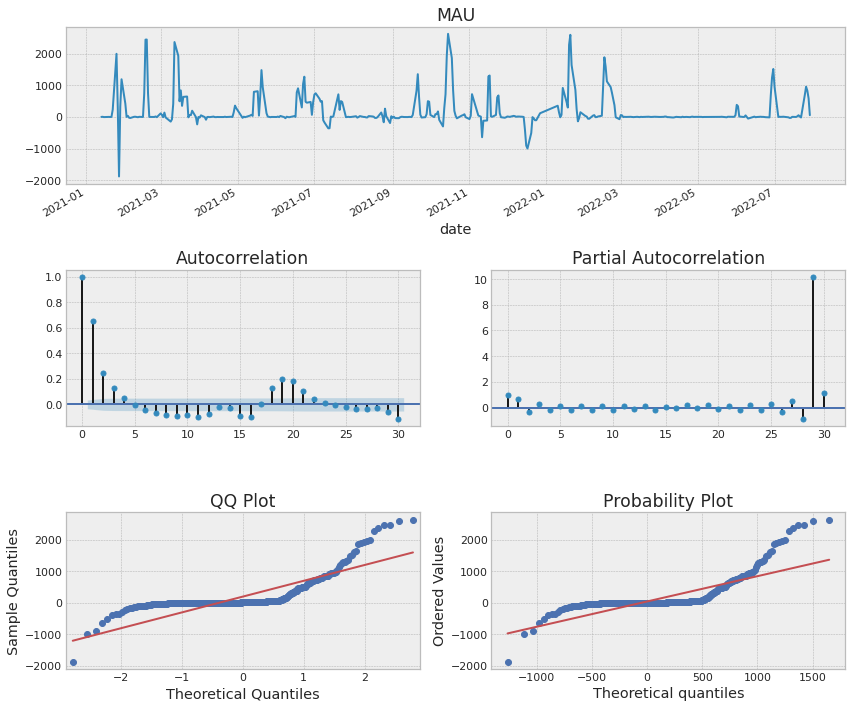

In [ ]:
tsplot(df_21_22.price.diff(1).dropna(), lags=30, title = 'MAU')

In [ ]:
# Не стационарный ряд, p-value 1.7 
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_21_22.price.diff(1).dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -7.652386e+00
p-value                        1.775172e-11
#Lags Used                     5.000000e+00
Number of Observations Used    3.750000e+02
Critical Value (1%)           -3.447909e+00
Critical Value (5%)           -2.869278e+00
Critical Value (10%)          -2.570892e+00
dtype: float64


In [ ]:
model = pm.auto_arima(df_21_22['price'], d=1, D=1,
                      m=30, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=inf, Time=30.08 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=5291.450, Time=0.32 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=5197.107, Time=10.56 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=25.49 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=5268.496, Time=1.29 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=5169.218, Time=31.68 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=87.11 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=31.47 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=5189.908, Time=25.39 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=5171.053, Time=38.47 sec
 ARIMA(1,1,1)(2,1,0)[30]             : AIC=5170.774, Time=61.68 sec
 ARIMA(0,1,1)(2,1,0)[30]             : AIC=5170.321, Time=28.93 sec
 ARIMA(2,1,1)(2,1,0)[30]             : AIC=inf, Time=96.43 sec
 ARIMA(1,1,0)(2,1,0)[30] intercept   : AIC=5169.218, Time=31.51 sec

Best model:  ARIMA(1,1,0)(2,1,0

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  382
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 30)   Log Likelihood               -2579.609
Date:                            Thu, 04 Aug 2022   AIC                           5169.218
Time:                                    12:47:15   BIC                           5188.522
Sample:                                         0   HQIC                          5176.901
                                            - 382                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -7.1260     21.232     -0.336      0.737     -48.740      34.488
ar.L1          0.2133      0.018     11.597      0.000       0.177       0.249
ar.S.L30      -0.5727      0.022    -26.369      0.000      -0.615      -0.530
ar.S.L60      -0.2713      0.026    -10.512      0.000      -0.322      -0.221
sigma2      1.163e+05   4970.390     23.395      0.000    1.07e+05    1.26e+05
===================================================================================
Ljung-Box (Q):                       65.35   Jarque-Bera (JB):               549.10
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#divide into train and validation set
train = df_21_22['price'][:int(0.85*(len(df_21_22)))]
test = df_21_22['price'][int(0.85*(len(df_21_22))):]

#plotting the data

In [ ]:
test

Series([], Name: price, dtype: int64)

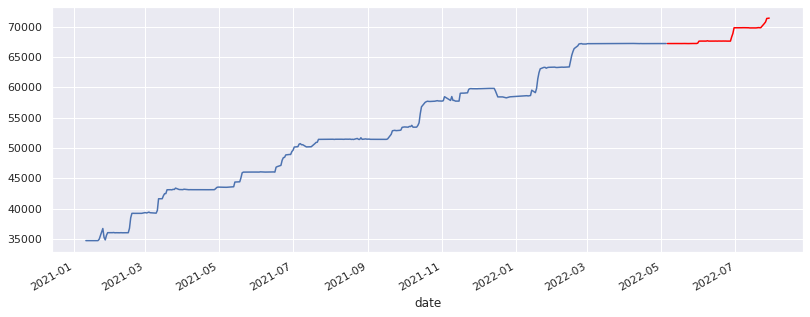

In [ ]:
train.plot()
test.plot(color = "red")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train,
                order=(1,1,0),seasonal_order=(2,1,0,30))
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  the underlying index is a RangeIndex or an integral index.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              price   No. Observations:                  324
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 30)   Log Likelihood               -2176.190
Date:                            Thu, 04 Aug 2022   AIC                           4360.379
Time:                                    12:55:22   BIC                           4375.100
Sample:                                         0   HQIC                          4366.275
                                            - 324                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1932      0.020      9.512      0.000       0.153       0.233
ar.S.L30      -0.5538      0.022    -25.334      0.000      -0.597      -0.511
ar.S.L60      -0.2628      0.026    -10.000      0.000      -0.314      -0.211
sigma2      1.318e+05   6038.187     21.826      0.000     1.2e+05    1.44e+05
===================================================================================
Ljung-Box (Q):                       59.80   Jarque-Bera (JB):               383.68
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

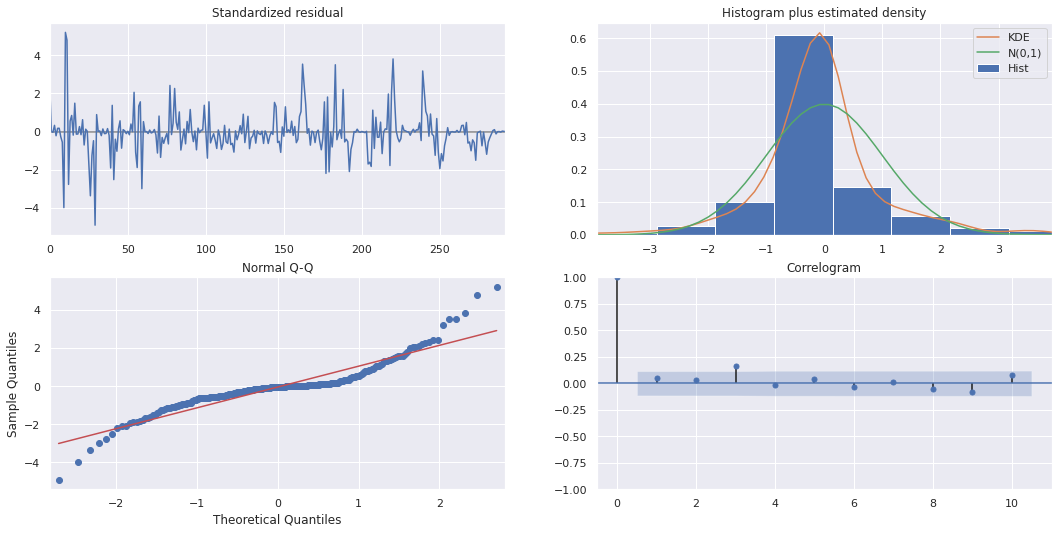

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics')
plt.show()

In [ ]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # If no frequency, try to get an inferred frequency


In [ ]:
df_21_22.index[324:381]

DatetimeIndex(['2022-05-06', '2022-05-11', '2022-05-12', '2022-05-13',
               '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19',
               '2022-05-20', '2022-05-23', '2022-05-24', '2022-05-25',
               '2022-05-26', '2022-05-27', '2022-05-30', '2022-05-31',
               '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-06',
               '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
               '2022-06-14', '2022-06-15', '2022-06-16', '2022-06-17',
               '2022-06-20', '2022-06-21', '2022-06-22', '2022-06-23',
               '2022-06-24', '2022-06-27', '2022-06-28', '2022-06-29',
               '2022-06-30', '2022-07-01', '2022-07-04', '2022-07-05',
               '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-11',
               '2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
      

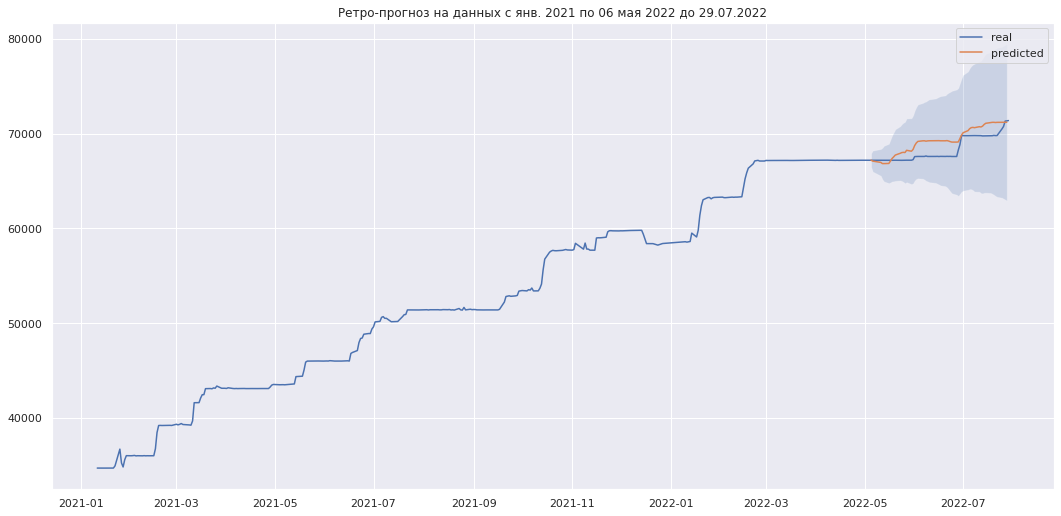

In [ ]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df_21_22.index, df_21_22.price, label='real')

# Plot the prediction means as line
plt.plot(df_21_22.index[323:381], mean, label='predicted')

plt.fill_between(df_21_22.index[323:381], conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)
plt.title("Ретро-прогноз на данных с янв. 2021 по 06 мая 2022 до 29.07.2022")
# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

### Попробуем на 3 месяца

In [ ]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
model_full = SARIMAX(df_21_22.price,
                order=(2, 1, 0),seasonal_order=(2,1,0,30))
results_full = model_full.fit()
results_full.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  the underlying index is a RangeIndex or an integral index.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              price   No. Observations:                  382
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 30)   Log Likelihood               -2579.679
Date:                            Thu, 04 Aug 2022   AIC                           5169.359
Time:                                    14:19:23   BIC                           5188.662
Sample:                                         0   HQIC                          5177.041
                                            - 382                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2086      0.018     11.379      0.000       0.173       0.245
ar.L2          0.0192      0.031      0.624      0.533      -0.041       0.080
ar.S.L30      -0.5713      0.022    -26.215      0.000      -0.614      -0.529
ar.S.L60      -0.2705      0.026    -10.529      0.000      -0.321      -0.220
sigma2      1.166e+05   5042.301     23.118      0.000    1.07e+05    1.26e+05
===================================================================================
Ljung-Box (Q):                       64.55   Jarque-Bera (JB):               571.52
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
model_full = SARIMAX(df.price,
                order=(2, 1, 0), seasonal_order=(4,1,0,30))
results_full = model_full.fit()
results_full.summary()

In [ ]:
forecast_object_full = results_full.get_forecast(steps=384)

mean_full = forecast_object_full.predicted_mean

conf_int_full = forecast_object_full.conf_int()

dates_full = mean_full.index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # If no frequency, try to get an inferred frequency


In [ ]:
df_21_22.index,

(DatetimeIndex(['2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
                '2021-01-15', '2021-01-18', '2021-01-19', '2021-01-20',
                '2021-01-21', '2021-01-22',
                ...
                '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
                '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
                '2022-07-28', '2022-07-29'],
               dtype='datetime64[ns]', name='date', length=382, freq=None),)

In [ ]:
# создаем список из дат для отображения данных на графике
import datetime
start = datetime.datetime.strptime("01-08-2022", "%d-%m-%Y")
predict_index = pd.date_range(start, periods = len(mean_full))

predict_index

DatetimeIndex(['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08',
               '2022-08-09', '2022-08-10',
               ...
               '2023-08-10', '2023-08-11', '2023-08-12', '2023-08-13',
               '2023-08-14', '2023-08-15', '2023-08-16', '2023-08-17',
               '2023-08-18', '2023-08-19'],
              dtype='datetime64[ns]', length=384, freq='D')

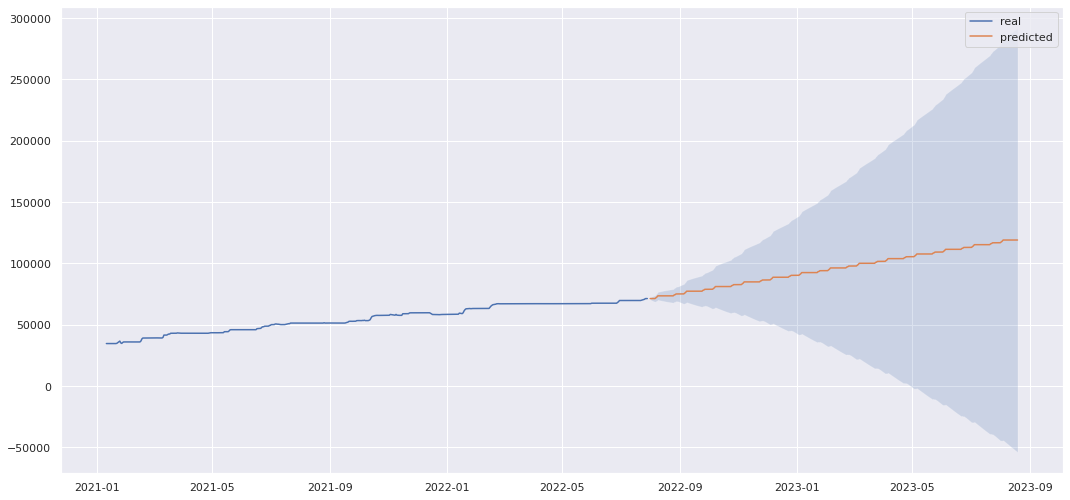

In [ ]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df_21_22.index, df_21_22.price, label='real')

# Plot the prediction means as line
plt.plot(predict_index, mean_full, label='predicted')

plt.fill_between(predict_index, conf_int_full.iloc[:,0], conf_int_full.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [ ]:
mean_full/1.2

382    59482.167791
383    59483.425895
384    59482.610574
385    59488.989508
386    59487.053714
           ...     
761    83155.247094
762    83150.012767
763    83151.201888
764    83150.841163
765    83163.309540
Length: 384, dtype: float64

### Вариант 2 (не см.) 

In [ ]:
model_full = SARIMAX(df.price,
                order=(2, 2, 1), seasonal_order=(1,1,1,6))
results_full = model_full.fit()
results_full.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  the underlying index is a RangeIndex or an integral index.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             price   No. Observations:                 1476
Model:             SARIMAX(2, 2, 1)x(1, 1, 1, 6)   Log Likelihood              -11044.714
Date:                           Thu, 04 Aug 2022   AIC                          22101.429
Time:                                   14:49:57   BIC                          22133.179
Sample:                                        0   HQIC                         22113.269
                                          - 1476                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0767      0.005     15.635      0.000       0.067       0.086
ar.L2          0.1259      0.013      9.717      0.000       0.101       0.151
ma.L1         -1.0000      2.258     -0.443      0.658      -5.425       3.425
ar.S.L6        0.0905      0.011      8.095      0.000       0.069       0.112
ma.S.L6       -1.0000      2.254     -0.444      0.657      -5.419       3.419
sigma2      1.668e+05   1.34e-05   1.25e+10      0.000    1.67e+05    1.67e+05
===================================================================================
Ljung-Box (Q):                      118.84   Jarque-Bera (JB):           4617892.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -9.75
Prob(H) (two-sided):                  0.07   Kurtosis:                       277.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.45e+27. Standard errors may be unstable.
"""

In [ ]:
forecast_object_full = results_full.get_forecast(steps=322)

mean_full = forecast_object_full.predicted_mean

conf_int_full = forecast_object_full.conf_int()

dates_full = mean_full.index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # If no frequency, try to get an inferred frequency


In [ ]:
start = datetime.datetime.strptime("01-08-2022", "%d-%m-%Y")
predict_index = pd.date_range(start, periods = len(mean_full))

predict_index

DatetimeIndex(['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08',
               '2022-08-09', '2022-08-10',
               ...
               '2023-06-09', '2023-06-10', '2023-06-11', '2023-06-12',
               '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-17', '2023-06-18'],
              dtype='datetime64[ns]', length=322, freq='D')

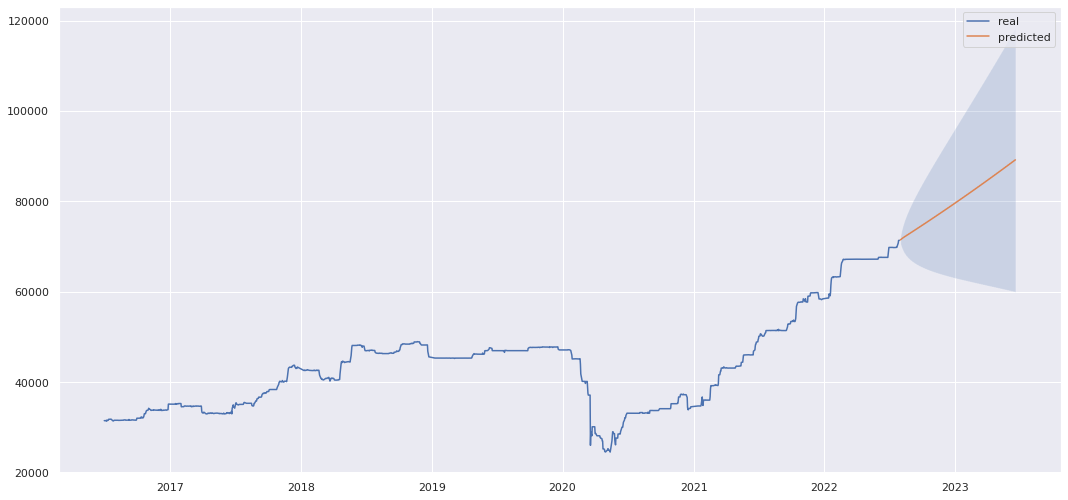

In [ ]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df.index, df.price, label='real')

# Plot the prediction means as line
plt.plot(predict_index, mean_full, label='predicted')

plt.fill_between(predict_index, conf_int_full.iloc[:,0], conf_int_full.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [ ]:
mean_full/1.2



1476    59560.645008
1477    59615.376299
1478    59674.559174
1479    59747.095865
1480    59791.080669
            ...     
1793    74129.646011
1794    74216.087206
1795    74227.286028
1796    74278.142453
1797    74317.918016
Length: 322, dtype: float64

In [ ]:
mean_full[120:]/1.2


1596    64899.615427
1597    64906.481495
1598    64953.005165
1599    64988.447974
1600    65037.959214
            ...     
1793    74129.646011
1794    74216.087206
1795    74227.286028
1796    74278.142453
1797    74317.918016
Length: 202, dtype: float64

In [ ]:
mean_full[120:].mean()/1.2
# январь

69525.31785571139

In [ ]:
df2

date
2016-07-31    31578.904762
2016-08-31    31558.043478
2016-09-30    31613.318182
2016-10-31    32571.238095
2016-11-30    33827.285714
                  ...     
2022-03-31    67183.000000
2022-04-30    67195.952381
2022-05-31    67200.777778
2022-06-30    67798.809524
2022-07-31    70097.095238
Freq: M, Name: price, Length: 73, dtype: float64

## Построение SARIMA на месячных данных. Итоговый вариант

In [ ]:
# Загрузка данных
df = pd.read_excel('/content/MAU_price.xlsx', parse_dates=['date'], index_col='date')

df.head()

,price,price_cl,volume,value,num_trades
date,,,,,
2016-07-01,31460,26216.666667,1080,33976800,4
2016-07-04,31458,26215.000000,1080,33975000,4
2016-07-05,31449,26207.500000,1080,33965400,4
2016-07-06,31403,26169.166667,1080,33915300,3
2016-07-07,31560,26300.000000,1080,34084800,2


In [ ]:
df_model = df[1:len(df)-28:]
df_model

,price,price_cl,volume,value,num_trades
date,,,,,
2016-07-04,31458,26215.000000,1080,33975000,4
2016-07-05,31449,26207.500000,1080,33965400,4
2016-07-06,31403,26169.166667,1080,33915300,3
2016-07-07,31560,26300.000000,1080,34084800,2
2016-07-08,31400,26166.666667,1080,33912000,2
...,...,...,...,...,...
2022-07-25,70501,58750.833333,1020,71910900,5
2022-07-26,70765,58970.833333,1260,89164500,9
2022-07-27,71334,59445.000000,1260,89880600,6


In [ ]:
# Перевод дневных цен в среднемесячные 
df2 = df_model["price"].resample('M').mean()
df2

date
2016-07-31    31584.850000
2016-08-31    31558.043478
2016-09-30    31613.318182
2016-10-31    32571.238095
2016-11-30    33827.285714
                  ...     
2022-03-31    67183.000000
2022-04-30    67195.952381
2022-05-31    67200.777778
2022-06-30    67798.809524
2022-07-31    70097.095238
Freq: M, Name: price, Length: 73, dtype: float64

In [ ]:
df2_update = df["price"].resample('M').mean()
df2_update

date
2016-07-31    31578.904762
2016-08-31    31558.043478
2016-09-30    31613.318182
2016-10-31    32571.238095
2016-11-30    33827.285714
                  ...     
2022-05-31    67200.777778
2022-06-30    67798.809524
2022-07-31    70097.095238
2022-08-31    71397.956522
2022-09-30    71399.200000
Freq: M, Name: price, Length: 75, dtype: float64

In [ ]:
df2[1:len(df2)-2:] 

date
2016-08-31    31558.043478
2016-09-30    31613.318182
2016-10-31    32571.238095
2016-11-30    33827.285714
2016-12-31    33865.684211
                  ...     
2022-03-31    67183.000000
2022-04-30    67195.952381
2022-05-31    67200.777778
2022-06-30    67798.809524
2022-07-31    70097.095238
Freq: M, Name: price, Length: 72, dtype: float64

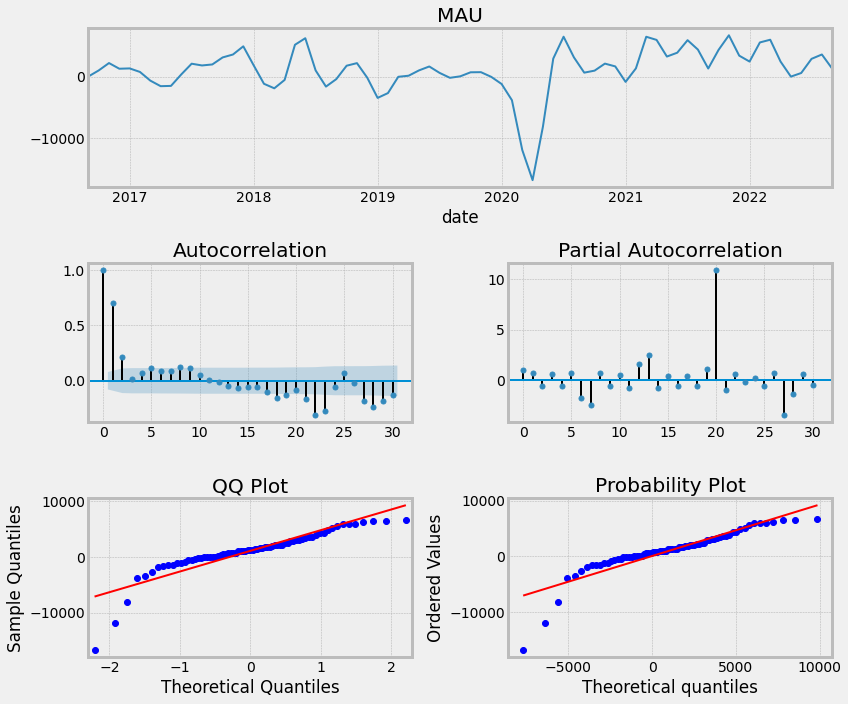

In [ ]:
# Анализ автокорреляций. 
tsplot(df2.diff(2).dropna(), lags=30, title = 'MAU')

In [ ]:
# Подбор лучшей модели путем минимизации критерия Акаике
# выполнено 4 августа!
model = pm.auto_arima(df2, d=2, D=1,
                      m=6, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=3, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[6]             : AIC=inf, Time=0.60 sec
 ARIMA(0,2,0)(0,1,0)[6]             : AIC=1225.658, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[6]             : AIC=1222.853, Time=0.07 sec
 ARIMA(0,2,1)(0,1,1)[6]             : AIC=1222.643, Time=0.15 sec
 ARIMA(0,2,1)(0,1,0)[6]             : AIC=1227.029, Time=0.03 sec
 ARIMA(0,2,1)(1,1,1)[6]             : AIC=1220.633, Time=0.58 sec
 ARIMA(0,2,1)(1,1,0)[6]             : AIC=1222.892, Time=0.07 sec
 ARIMA(0,2,1)(2,1,1)[6]             : AIC=inf, Time=0.94 sec
 ARIMA(0,2,1)(1,1,2)[6]             : AIC=inf, Time=1.40 sec
 ARIMA(0,2,1)(0,1,2)[6]             : AIC=1224.329, Time=0.34 sec
 ARIMA(0,2,1)(2,1,0)[6]             : AIC=1224.890, Time=0.33 sec
 ARIMA(0,2,1)(2,1,2)[6]             : AIC=inf, Time=2.20 sec
 ARIMA(1,2,1)(1,1,1)[6]             : AIC=1222.664, Time=0.75 sec
 ARIMA(0,2,2)(1,1,1)[6]             : AIC=1212.585, Time=1.36 sec
 ARIMA(0,2,2)(0,1,1)[6]             : AIC=inf, Time=0

In [ ]:
model_full = SARIMAX(df2,
                order=(2, 2, 1), seasonal_order=(1,1,1,6))
results_full = model_full.fit()
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             price   No. Observations:                   73
Model:             SARIMAX(2, 2, 1)x(1, 1, 1, 6)   Log Likelihood                -597.331
Date:                           Thu, 08 Sep 2022   AIC                           1206.661
Time:                                   08:18:06   BIC                           1219.708
Sample:                               07-31-2016   HQIC                          1211.809
                                    - 07-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6371      0.169      3.779      0.000       0.307       0.968
ar.L2         -0.1803      0.122     -1.484      0.138      -0.418       0.058
ma.L1         -0.9312      0.123     -7.593      0.000      -1.172      -0.691
ar.S.L6        0.5409      0.226      2.396      0.017       0.098       0.983
ma.S.L6       -0.8757      0.298     -2.939      0.003      -1.460      -0.292
sigma2      6.475e+06   1.36e+06      4.746      0.000     3.8e+06    9.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 4.05
Prob(Q):                              0.53   Prob(JB):                         0.13
Heteroskedasticity (H):               1.06   Skew:                            -0.29
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# ячейка формирования прогноза, доверительных интервалов и т.д.
forecast_object_full = results_full.get_forecast(steps=17)

mean_full = forecast_object_full.predicted_mean

conf_int_full = forecast_object_full.conf_int()

dates_full = mean_full.index

In [ ]:
# старый прогноз
mean_full/1.2

2022-08-31    60621.852392
2022-09-30    62067.360430
2022-10-31    62249.029411
2022-11-30    62693.237131
2022-12-31    63319.605725
2023-01-31    65119.821227
2023-02-28    66732.431679
2023-03-31    67762.131686
2023-04-30    67988.244993
2023-05-31    68636.821842
2023-06-30    69299.051543
2023-07-31    71001.322717
2023-08-31    72254.860860
2023-09-30    73021.815333
2023-10-31    73233.992566
2023-11-30    73955.167472
2023-12-31    74598.918719
Freq: M, dtype: float64

In [ ]:
## повтор прогноза от 4 августа, 8 сентября
mean_full/1.2

2022-08-31    60621.729219
2022-09-30    62067.195740
2022-10-31    62248.681366
2022-11-30    62692.664980
2022-12-31    63318.873289
2023-01-31    65119.084152
2023-02-28    66731.451084
2023-03-31    67761.018696
2023-04-30    67986.831355
2023-05-31    68635.067291
2023-06-30    69297.027883
2023-07-31    70999.250973
2023-08-31    72252.392283
2023-09-30    73019.096695
2023-10-31    73230.889685
2023-11-30    73951.656868
2023-12-31    74595.058505
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# корзины для прогнозов
forecasts = []
res = results_full # название модели покороче
#forecasts.append(res.forecast())
forecasts

# добавили наблюдение за август
res = res.append(df2_update.iloc[-2:-1], refit=False)
forecasts.append(res.forecast())
# добавили наблюдение за сентябрь
#res = res.append(df2_update.iloc[-1:], refit=False)
#forecasts.append(res.forecast())

forecasts

# если хотим кросс-валидацию сделать
# https://stackoverflow.com/questions/66870279/arima-forecasting-next-steps-without-updating-model

[2022-09-30    72178.424403
 Freq: M, dtype: float64]

In [ ]:
# таблица прогноза от 08 сентября
res.get_forecast(steps=16).predicted_mean/1.2

2022-09-30    60148.687003
2022-10-31    59946.669239
2022-11-30    60209.930048
2022-12-31    60710.107557
2023-01-31    62382.793158
2023-02-28    63105.354947
2023-03-31    63457.996615
2023-04-30    63279.699624
2023-05-31    63658.900398
2023-06-30    64088.237408
2023-07-31    65557.021022
2023-08-31    66019.357149
2023-09-30    66151.509827
2023-10-31    65928.506655
2023-11-30    66313.147582
2023-12-31    66646.726046
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# август
df2_update[-2:-1]
# сентябрь
df2_update[-1:]

date
2022-09-30    71399.2
Freq: M, Name: price, dtype: float64

In [ ]:
nobs = len(df2_update)
nobs

n_train = len(df2)
n_train

75

### errors

In [ ]:
# Для расчет R-squared
# корзины для прогнозов
forecasts_r = []
res_r = results_full # название модели покороче
#forecasts.append(res.forecast())

# добавили наблюдение за август
res = res.append(df2_update.iloc[-2:-1], refit=False)
forecasts.append(res.forecast())
# добавили наблюдение за сентябрь
#res = res.append(df2_update.iloc[-1:], refit=False)
#forecasts.append(res.forecast())

forecasts

# если хотим кросс-валидацию сделать
# https://stackoverflow.com/questions/66870279/arima-forecasting-next-steps-without-updating-model

In [ ]:
forecasts_r = []
res_r = results_full
#forecasts_r.append(res_r.forecast())
#forecasts_r.append(31578.9)

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in range(0, len(df2)):
    # Update the results by appending the next observation
    res_r = res_r.append(df2.values[t:t + 1], refit=False)
    
    # Produce a forecast for t+1 based on data through t
    forecasts_r.append(res_r.forecast())

forecasts_r

[2022-09-30    4188.742137
 Freq: M, dtype: float64, 2022-10-31    37091.526747
 Freq: M, dtype: float64, 2022-11-30    30988.208225
 Freq: M, dtype: float64, 2022-12-31    32356.557705
 Freq: M, dtype: float64, 2023-01-31    35076.117299
 Freq: M, dtype: float64, 2023-02-28    5584.264861
 Freq: M, dtype: float64, 2023-03-31    53585.319353
 Freq: M, dtype: float64, 2023-04-30    29075.002545
 Freq: M, dtype: float64, 2023-05-31    35434.119489
 Freq: M, dtype: float64, 2023-06-30    32415.46852
 Freq: M, dtype: float64, 2023-07-31    33148.709648
 Freq: M, dtype: float64, 2023-08-31    32683.145864
 Freq: M, dtype: float64, 2023-09-30    36329.576269
 Freq: M, dtype: float64, 2023-10-31    35090.999219
 Freq: M, dtype: float64, 2023-11-30    37675.189627
 Freq: M, dtype: float64, 2023-12-31    39619.465121
 Freq: M, dtype: float64, 2024-01-31    42672.802637
 Freq: M, dtype: float64, 2024-02-29    44143.985037
 Freq: M, dtype: float64, 2024-03-31    42092.098064
 Freq: M, dtype: floa

In [ ]:
# r^squaerd если мы сперва добавим только 1 наблюдение
r2_score(forecasts_r[1:], df2[1:] )

0.8577569734699427

In [ ]:
forecasts_r_6m = []
res_r = results_full

res_r = res_r.append(df2.values[0:2], refit=False)

#forecasts_r.append(res_r.forecast())
#forecasts_r.append(31578.9)

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in range(2, len(df2)):
    # Update the results by appending the next observation
    res_r = res_r.append(df2.values[t:t + 1], refit=False)
    
    # Produce a forecast for t+1 based on data through t
    forecasts_r_6m.append(res_r.forecast())

forecasts_r_6m

[2022-11-30    30988.208225
 Freq: M, dtype: float64, 2022-12-31    32356.557705
 Freq: M, dtype: float64, 2023-01-31    35076.117299
 Freq: M, dtype: float64, 2023-02-28    5584.264861
 Freq: M, dtype: float64, 2023-03-31    53585.319353
 Freq: M, dtype: float64, 2023-04-30    29075.002545
 Freq: M, dtype: float64, 2023-05-31    35434.119489
 Freq: M, dtype: float64, 2023-06-30    32415.46852
 Freq: M, dtype: float64, 2023-07-31    33148.709648
 Freq: M, dtype: float64, 2023-08-31    32683.145864
 Freq: M, dtype: float64, 2023-09-30    36329.576269
 Freq: M, dtype: float64, 2023-10-31    35090.999219
 Freq: M, dtype: float64, 2023-11-30    37675.189627
 Freq: M, dtype: float64, 2023-12-31    39619.465121
 Freq: M, dtype: float64, 2024-01-31    42672.802637
 Freq: M, dtype: float64, 2024-02-29    44143.985037
 Freq: M, dtype: float64, 2024-03-31    42092.098064
 Freq: M, dtype: float64, 2024-04-30    43384.670727
 Freq: M, dtype: float64, 2024-05-31    40074.562019
 Freq: M, dtype: flo

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

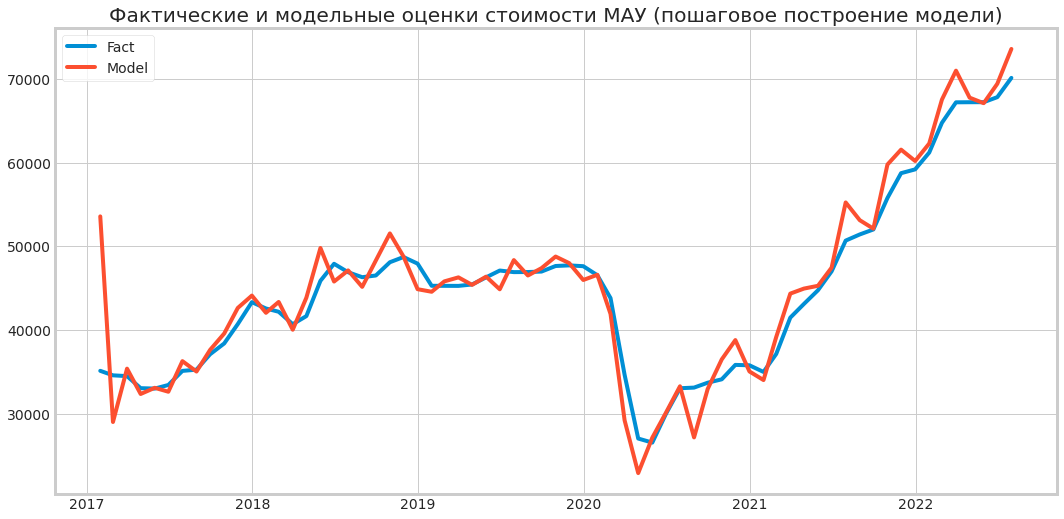

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df2[6:].index, df2[6:].values, label = 'Fact')
plt.plot(df2[6:].index, forecasts_r_6m, label = 'Model')
plt.legend()
plt.title('Фактические и модельные оценки стоимости МАУ (пошаговое построение модели)');

In [ ]:
# r^squaerd при добавлении первых 6 месяцев 2016 г. (для того, чтобы были предыдущие значения и регрессия не занулялась)
r2_score(forecasts_r_6m[:], df2[6:] )

0.9225782782541504

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,
 mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
range()

In [ ]:
df2.iloc[72]

70097.09523809524

In [ ]:
df2.values[0:12]

array([31584.85      , 31558.04347826, 31613.31818182, 32571.23809524,
       33827.28571429, 33865.68421053, 35174.52941176, 34637.72222222,
       34543.31818182, 33107.85      , 33058.4       , 33487.19047619])

In [ ]:
df2[0:2]

date
2016-07-31    31584.850000
2016-08-31    31558.043478
Freq: M, Name: price, dtype: float64

In [ ]:
res_r.predict(start = 2, end = 12)

2016-09-30    28849.201509
2016-10-31    34326.853202
2016-11-30    35711.311841
2016-12-31    35624.908522
2017-01-31    54817.150827
2017-02-28    19924.928441
2017-03-31    36736.229912
2017-04-30    34056.068545
2017-05-31    31315.843136
2017-06-30    31077.508740
2017-07-31    35868.068883
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
[x*3 for x in range(2, 21) ]

[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]

In [ ]:
forecasts_r_Y = []
res_r = results_full

res_r = res_r.append(df2.values[0:2], refit=False)

#forecasts_r.append(res_r.forecast())
#forecasts_r.append(31578.9)

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
#for t in (2, 14, 26, 38, 50):
#for t in (6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69):
for t in (2, 8, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68):
    forecasts_r_Y.append(res_r.get_forecast(steps = 6).predicted_mean)
    res_r = res_r.append(df2.values[t:t + 6], refit=False)

    

#res_r = res_r.append(df2.values[50:50 + 12], refit=False)
#forecasts_r_Y.append(res_r.get_forecast(steps=10).predicted_mean)
forecasts_r_Y

[2022-10-31    37091.526747
 2022-11-30    40342.595933
 2022-12-31    40877.005204
 2023-01-31    41424.674098
 2023-02-28    13854.627910
 2023-03-31    11955.408574
 Freq: M, Name: predicted_mean, dtype: float64, 2023-04-30    29075.002545
 2023-05-31    26098.861768
 2023-06-30    25189.624227
 2023-07-31    24743.961804
 2023-08-31    23248.044807
 2023-09-30    22082.707550
 Freq: M, Name: predicted_mean, dtype: float64, 2023-10-31    35090.999219
 2023-11-30    34155.673563
 2023-12-31    34099.158425
 2024-01-31    34634.359131
 2024-02-29    34200.475185
 2024-03-31    34046.555239
 Freq: M, Name: predicted_mean, dtype: float64, 2024-04-30    43384.670727
 2024-05-31    44601.895121
 2024-06-30    46549.484398
 2024-07-31    48910.482530
 2024-08-31    47474.978595
 2024-09-30    47343.700662
 Freq: M, Name: predicted_mean, dtype: float64, 2024-10-31    45183.407020
 2024-11-30    46007.816321
 2024-12-31    49122.834788
 2025-01-31    51020.827935
 2025-02-28    49405.885284


In [ ]:
flatten_predictions = [item for sublist in forecasts_r_Y for item in sublist]
len(flatten_predictions)

flatten_predictions

In [ ]:
len(flatten_predictions)

72

In [ ]:
df2[2:2+len(flatten_predictions)]

date
2016-09-30    31613.318182
2016-10-31    32571.238095
2016-11-30    33827.285714
2016-12-31    33865.684211
2017-01-31    35174.529412
                  ...     
2022-03-31    67183.000000
2022-04-30    67195.952381
2022-05-31    67200.777778
2022-06-30    67798.809524
2022-07-31    70097.095238
Freq: M, Name: price, Length: 71, dtype: float64

In [ ]:
df2_update[62:74]

date
2021-09-30    52026.318182
2021-10-31    55777.666667
2021-11-30    58736.850000
2021-12-31    59188.526316
2022-01-31    61191.875000
2022-02-28    64740.315789
2022-03-31    67183.000000
2022-04-30    67195.952381
2022-05-31    67200.777778
2022-06-30    67798.809524
2022-07-31    70097.095238
2022-08-31    71397.956522
Freq: M, Name: price, dtype: float64

In [ ]:
flatten_predictions[60:72]

[67507.40112982152,
 71509.91512541025,
 74817.59861625137,
 76400.93194052749,
 78298.76885397064,
 81535.50227742789,
 73545.89931208086,
 75855.71932505006,
 76561.3297990216,
 77451.44971136902,
 78703.27238553278,
 80532.54208208736]

In [ ]:
from scipy import stats
stats.spearmanr(flatten_predictions[60:72],df2_update.values[62:74])

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [ ]:
data_t = pd.DataFrame({'pred':flatten_predictions[60:72], 'fact': df2_update.values[62:74]})
data_t

,pred,fact
0,53132.959018,52026.318182
1,54009.868230,55777.666667
2,55790.840560,58736.850000
3,58257.862841,59188.526316
4,60812.180627,61191.875000
5,61867.969899,64740.315789
6,67507.401130,67183.000000
7,71509.915125,67195.952381
8,74817.598616,67200.777778
9,76400.931941,67798.809524


In [ ]:
data_t['y-yhat'] = (data_t['pred']/1000 - data_t['fact']/1000)**2
data_t['y-ymean'] = (data_t['pred']/1000 - np.mean(data_t['fact']/1000))**2

data_t['pred*0.9'] = data_t['pred'] * 0.9
data_t

,pred,fact,y-yhat,y-ymean,pred*0.9
0,53132.959018,52026.318182,1.224654,108.402170,47819.663116
1,54009.868230,55777.666667,3.125111,90.911020,48608.881407
2,55790.840560,58736.850000,8.678972,60.120712,50211.756504
3,58257.862841,59188.526316,0.866135,27.949540,52432.076557
4,60812.180627,61191.875000,0.144168,7.466090,54730.962564
5,61867.969899,64740.315789,8.250371,2.811073,55681.172909
6,67507.401130,67183.000000,0.105236,15.703830,60756.661017
7,71509.915125,67195.952381,18.610275,63.446320,64358.923613
8,74817.598616,67200.777778,58.015960,127.080604,67335.838755
9,76400.931941,67798.809524,73.996510,165.285392,68760.838746


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_t['fact'], data_t['pred'])

r_value

0.9413110929013182

In [ ]:
1 - np.sum(data_t['y-yhat'].values)/np.sum(data_t['y-ymean'].values)

-0.012148191080048276

In [ ]:
(data_t['pred'] - data_t['fact'])**2

In [ ]:
# R^squared, last 12 values and all values
round(stats.pearsonr(flatten_predictions[60:72],df2_update.values[62:74])[0],2)
#round(stats.pearsonr(flatten_predictions[:len(df2.values[2:])],df2_update.values[2:len(flatten_predictions)+1])[[0]],2)

(0.941311092901318, 4.966713766311482e-06)
(0.8460341229599518, 1.594308338199563e-20)


In [ ]:
len(flatten_predictions[:72]) == len(df2_update.values[2:74])

True

In [ ]:
fact_values = df2_update.values[2:len(flatten_predictions)+1]/1.2
predict_values = pd.DataFrame({'predict': flatten_predictions[:len(df2.values[2:])]})/1.2

In [ ]:
# сдвиг направо!
i = 18
r_2_plot = 'R^squared: ' + str(round(r2_score(flatten_predictions[i:72], df2_update.values[i+2:74]), 2))
spearman_k_plot = 'Корреляция Спирмана: ' + str(round(stats.spearmanr(flatten_predictions[i:72], df2_update.values[i+2:74])[0], 2))

r_2_plot_12 = 'R^squared: ' + str(round(r2_score(flatten_predictions[60:72], df2_update.values[62:74]), 2))

spearman_k_plot_12 = 'Корреляция Спирмана: ' + str(round(round(r2_score(flatten_predictions[6:72], df2_update.values[8:74]), 2), 2))

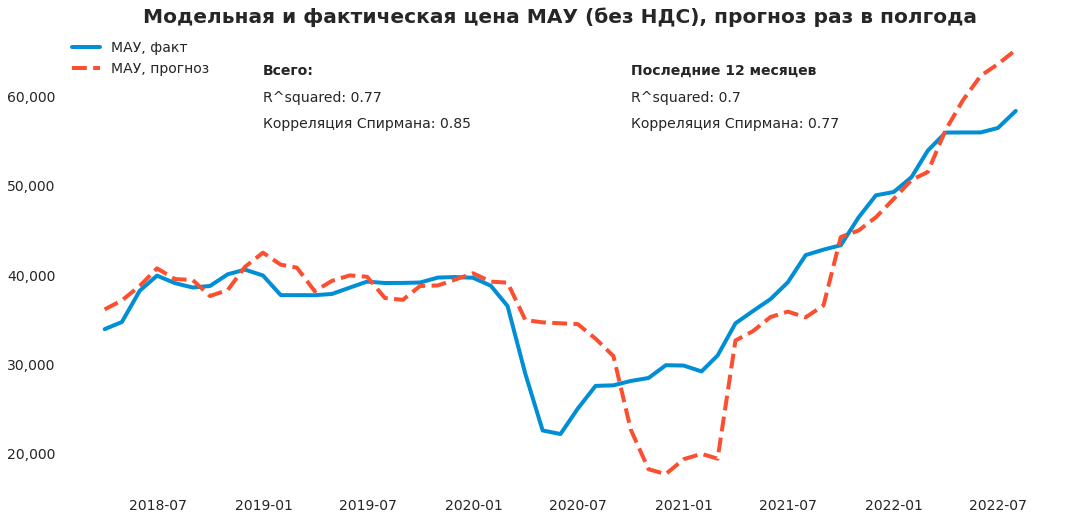

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df2[i+2:2+len(flatten_predictions)].index, fact_values[i:], label = 'МАУ, факт')
plt.plot(df2[i+2:2+len(flatten_predictions)].index, predict_values[i:] , label = 'МАУ, прогноз', linestyle='--')


plt.grid(False)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(frameon=False)
plt.box(False)
plt.title('Модельная и фактическая цена МАУ (без НДС), прогноз раз в полгода', fontweight="bold")

plt.text(df2[i+2:2+len(flatten_predictions)].index[9], fact_values[i-4] + 28500, 'Всего:', fontweight="bold" );
plt.text(df2[i+2:2+len(flatten_predictions)].index[9], fact_values[i-4] + 25500, r_2_plot );
plt.text(df2[i+2:2+len(flatten_predictions)].index[9], fact_values[i-4] + 22500, spearman_k_plot );


plt.text(df2[i+2:2+len(flatten_predictions)].index[30], fact_values[i-4] + 28500, 'Последние 12 месяцев', fontweight="bold" );
plt.text(df2[i+2:2+len(flatten_predictions)].index[30], fact_values[i-4] + 25500, r_2_plot_12 );
plt.text(df2[i+2:2+len(flatten_predictions)].index[30], fact_values[i-4] + 22500, spearman_k_plot_12 );


### Дальнейшее

In [ ]:
# Таблица прогноза
# 4 августа
#pd.DataFrame({'index':mean_full.index, 'mau':mean_full.values/1.2})

,index,mau
0,2022-08-31,60621.852392
1,2022-09-30,62067.360430
2,2022-10-31,62249.029411
3,2022-11-30,62693.237131
4,2022-12-31,63319.605725
5,2023-01-31,65119.821227
6,2023-02-28,66732.431679
7,2023-03-31,67762.131686
8,2023-04-30,67988.244993
9,2023-05-31,68636.821842


In [ ]:
# Формирование списка дат на 17 кварталов (необходимо для построения графика в Python ниже)
start = "2022-8-31"
end = "2024-01-31"
predict_index= pd.date_range(start, end, freq='MS')

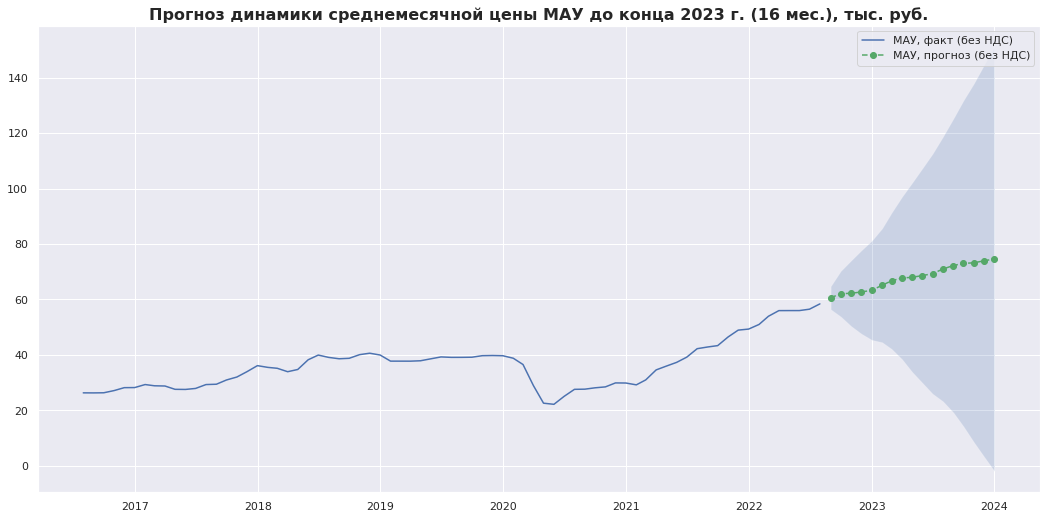

In [ ]:
# График на 4 августа
plt.figure(figsize=(16,8))

# График фактического МАУ
plt.plot(df2.index, df2/1.2/1000, label='МАУ, факт (без НДС)')

# График прогнозного МАУ
plt.plot(predict_index, mean_full/1.2/1000, 'go--', label='МАУ, прогноз (без НДС)')

plt.fill_between(predict_index, conf_int_full.iloc[:,0]/1.2/1000, conf_int_full.iloc[:,1]/1.2/1000, alpha=0.2)
plt.title(label = "Прогноз динамики среднемесячной цены МАУ до конца 2023 г. (16 мес.), тыс. руб.", fontweight='bold', fontsize  = 16)
# Plot legend and show figure
plt.legend()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('predtest')
plt.show()